In [16]:
import io
import os
import unicodedata
import string
import glob
import torch
import random

In [17]:
# alphabet small + capital letter + ",.;'"
ALL_LETTERS = string.ascii_letters + ".,;'"
N_LETTERS = len(ALL_LETTERS)
print(N_LETTERS)
print(ALL_LETTERS)

56
abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,;'


In [18]:
# turn a unicode string to plain ascii,
def unicode_to_ascii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD',s)
      if unicodedata.category(c) != 'Mn'
      and c in ALL_LETTERS
  )

def load_data():
  # build the category lines dctionary, a list of names per language
  category_lines = {}
  all_categories = []

  def find_files(path):
    return glob.glob(path)

  # read a file and split into lines
  def read_lines(filename):
    lines= io.open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

  for filename in find_files('/content/drive/MyDrive/data/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)

    lines = read_lines(filename)
    category_lines[category] = lines

  return category_lines, all_categories

In [19]:
'''
to represent a single letter, we use a "one-hot vector" of size <1 x n_letters>.
a one-hot vector is filled with zeros except for 1 at index of current letter, e.g., "b" = <0 1 0 0 0 ...>

to make a word, wwe join a bunch of those, into a 2D mattrix <line_length x 1 x n_letters>.

that extra 1 dimension is because pytorch assumes everything is in batches - we're just using a batch size of 1 here.
'''

'\nto represent a single letter, we use a "one-hot vector" of size <1 x n_letters>.\na one-hot vector is filled with zeros except for 1 at index of current letter, e.g., "b" = <0 1 0 0 0 ...>\n\nto make a word, wwe join a bunch of those, into a 2D mattrix <line_length x 1 x n_letters>.\n\nthat extra 1 dimension is because pytorch assumes everything is in batches - we\'re just using a batch size of 1 here. \n'

In [20]:
# find letter index from all_letters, e.g., "a"=0
def letter_to_index(letter):
  return ALL_LETTERS.find(letter)


In [21]:
# just for demo, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
  tensor = torch.zeros(1,N_LETTERS)
  tensor[0][letter_to_index(letter)] = 1
  return tensor



In [22]:
# turn a line into a <line_length x 1 x n_letters>
# or an array of one-hot letter vectors

def line_to_tensor(line):
  tensor = torch.zeros(len(line),1,N_LETTERS)
  for i, letter in enumerate(line):
    tensor[i][0][letter_to_index(letter)] = 1
  return tensor


In [23]:
def random_training_example(category_lines,all_categories):

  def random_choice(a):
    random_idx = random.randint(0, len(a)-1)
    return a[random_idx]

  category = random.choice(all_categories)
  line = random_choice(category_lines[category])
  category_tensor = torch.tensor([all_categories.index(category)], dtype =torch.long)
  line_tensor = line_to_tensor(line)

  return category, line, category_tensor, line_tensor


##**Implementation of RNN**

In [24]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


In [37]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input_tensor, hidden_tensor):
    combined = torch.cat((input_tensor, hidden_tensor), 1)

    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)

    return output, hidden

  # a helper function
  def init_hidden(self):
    return torch.zeros(1, self.hidden_size)


In [38]:
category_lines, all_categories = load_data()
n_categories = len(all_categories)
n_categories

18

In [39]:
n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)

In [41]:
# helper function

def category_from_output(output):
  category_idx = torch.argmax(output).item()
  print(category_idx)
  print(all_categories[category_idx])
  return all_categories[category_idx]

In [42]:
criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr = learning_rate)


In [43]:
def train(line_tensor, category_tensor):
  hidden = rnn.init_hidden()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  loss = criterion(output, category_tensor)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return output, loss.item()


5
Greek
4999 4.999 0.6734 Sklavenitis / Greek Correct
5
Greek
9999 9.998999999999999 1.4244 Pantelas / Greek Correct
2
German
14999 14.999 2.6579 Keefe / German Wrong Irish
0
Portuguese
19999 19.999 2.1982 Gallego / Portuguese Wrong Spanish
10
Irish
24999 24.999 1.6905 Macdonald / Irish Wrong Scottish
8
Polish
29999 29.999 0.2886 Sokolofsky / Polish Correct
5
Greek
34999 34.999 0.2499 Panoulias / Greek Correct
9
Arabic
39999 39.999 2.5064 Kumagae / Arabic Wrong Japanese
10
Irish
44999 44.999 0.0811 O'Gorman / Irish Correct
1
Italian
49999 49.999 1.5359 Moreno / Italian Wrong Spanish
4
Korean
54999 54.998999999999995 1.0363 Chin / Korean Correct
8
Polish
59999 59.999 2.2202 Winter / Polish Wrong German
13
French
64999 64.999 1.4189 Janvier / French Correct
2
German
69999 69.999 1.1705 Blecher / German Correct
17
Scottish
74999 74.99900000000001 0.3906 Gibson / Scottish Correct
5
Greek
79999 79.999 1.5627 Aonghus / Greek Wrong Irish
16
Spanish
84999 84.999 0.6563 Escarra / Spanish Correc

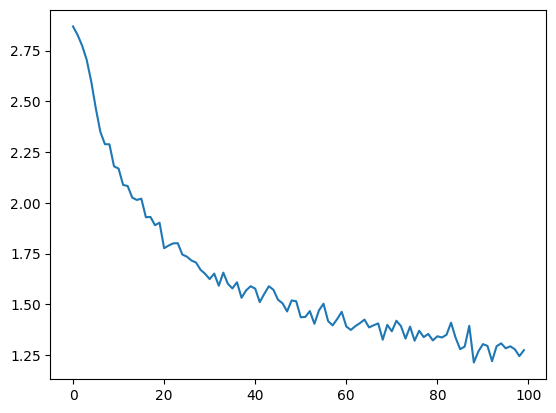

KeyboardInterrupt: Interrupted by user

In [44]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000,5000
n_iter = 100000
for i in range(n_iter):
  category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
  output, loss = train(line_tensor, category_tensor)
  current_loss += loss

  if(i+1)% plot_steps==0:
    all_losses.append(current_loss / plot_steps)
    current_loss = 0

  if(i+1)%print_steps ==0:

    guess = category_from_output(output)
    correct = 'Correct' if guess==category else f'Wrong {category}'
    print(f'{i} {i/n_iter * 100} {loss:.4f} {line} / {guess} {correct}')

plt.figure()
plt.plot(all_losses)
plt.show()

def predict(input_line):
  print(f'\n> {input_line}')

  with torch.no_grad():
    line_tensor = line_to_tensor(input_line)

    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
      output,hidden = rnn(line_tensor[i], hidden)

    guess = category_from_output(output)
    print(guess)




In [45]:
while True:
  sentence = input("input: ")
  if sentence=='quit':
    break
  predict(sentence)

input: acker

> acker
2
German
German
input: abbate

> abbate
13
French
French
input: adler

> adler
2
German
German
input: abaimov

> abaimov
14
Russian
Russian
input: bei

> bei
8
Polish
Polish
input: bao

> bao
11
Chinese
Chinese
input: bei

> bei
8
Polish
Polish
input: ban

> ban
11
Chinese
Chinese
input: au-yong

> au-yong
10
Irish
Irish
input: quit
